In [42]:
import pandas as pd
import numpy as np
import csv
import glob
import matplotlib.pyplot as plt
import datetime

In [43]:
output_path = r'/Users/dancohen/Dropbox/E4 stuff/test data/EDA_All_Data'

Helper function that returns a list of floats iterated upwards by sample rate


In [44]:
def iterate_sample_rate(df_length, fs):
    # returns list of floats starting from zero iterated upward by sample rate
    result = []
    curr_time = 0.0
    result.append(curr_time)
    
    for i in range(df_length-1):
        curr_time += 1.0/fs
        result.append(curr_time)
    return result

In [45]:
file_path = r'/Users/dancohen/Dropbox/E4 stuff/test data'
output_path = r'/Users/dancohen/Dropbox/E4 stuff/test data/IBI_All_Data'
all_folders = glob.glob(file_path + "/PRF*")

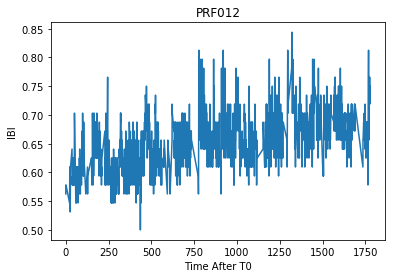

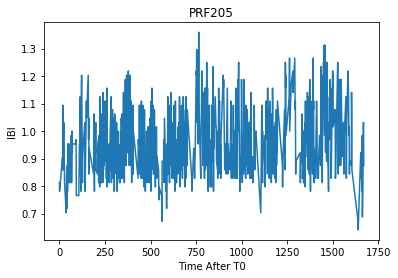

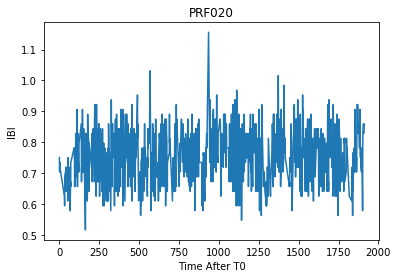

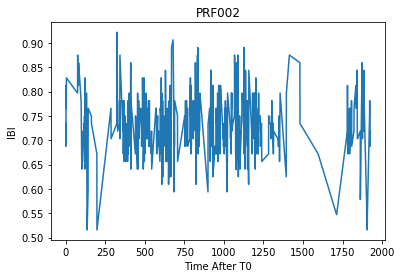

In [46]:
ibi_list = []
for folder in all_folders:
    spl = folder.split('/')
    
    #Folder names are 'PRF###' (participant ID) and we are interested in the ID
    part_id = spl[len(spl)-1][3:]
    
    ibi_df_raw = pd.read_csv(folder+"/IBI.csv")
    starting_timestamp = ibi_df_raw.columns[0]
    start_seconds = ibi_df_raw.loc[0].iat[0]
    
    #Normalize T0 down to 0 for the rest of the column.  This will make plotting data against each other easier later
    normalized_time = ibi_df_raw[starting_timestamp].apply(lambda x: x-start_seconds)
    ibi_df_raw[starting_timestamp] = normalized_time
    
    ibi_df = ibi_df_raw.rename(columns={starting_timestamp: "Time_After_T0", " IBI":part_id})
    ibi_list.append(ibi_df.transpose())
    
    plt.plot(ibi_df['Time_After_T0'], ibi_df[part_id] )
    plt.title("PRF{}".format(part_id))
    plt.ylabel('IBI')
    plt.xlabel('Time After T0')
    plt.savefig(output_path+"/IBI{}.pdf".format(part_id))
    plt.show()

In [47]:
df = pd.concat(ibi_list)
df = df.transpose()

In [48]:
df

,Time_After_T0,012,Time_After_T0,205,Time_After_T0,020,Time_After_T0,002
0,0.000000,0.562526,0.000000,0.812537,0.000000,0.750034,0.000000,0.734409
1,0.578152,0.578151,0.781286,0.781286,0.718783,0.718783,0.687532,0.687531
2,1.156303,0.578151,17.125784,0.906291,1.421940,0.703157,1.500069,0.812537
3,21.969756,0.546900,17.985198,0.859414,2.156349,0.734409,2.265729,0.765660
4,22.563533,0.593777,18.985244,1.000046,2.875132,0.718783,3.078266,0.812537
5,23.157310,0.593777,20.079044,1.093800,31.454565,0.625029,3.906429,0.828163
6,23.766713,0.609403,20.938459,0.859414,32.063968,0.609403,74.300276,0.796911
7,24.344864,0.578151,21.860376,0.921917,32.657745,0.593777,75.175316,0.875040
8,24.938642,0.593777,22.813544,0.953169,33.298399,0.640654,76.019105,0.843789
9,25.548045,0.609403,23.844842,1.031297,33.985931,0.687531,76.862894,0.843789


In [49]:
df.to_csv(output_path+"/IBI_All_Participants.csv")